In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 1.07
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 0.90


**seu_ns: SEU-Allen's data**

**all_ns: SEU + Janelia's data**

Input .swc data file, total **1641**.

ns = nmt.neuron_set('/home/penglab/FeaCal/AllData15Nov')
pickle.dump([ns], open("/home/penglab/FeaCal/all_ns.pickle", "wb"))

In [2]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

# 2.1) Distribution of soma location
* Set the *thre* value to determine the threshold for showing the region distribution
* mouseDF is a dataframe recording the ['Child ID', 'Child num', 'ABBR', 'FatherRe'] of 1327 brain regions
* Not going to write mouseDF to the pkg, just to show the result

## 2.1.1) Based on 7 regions
* including Isocortex, OLF, HPF, CTXsp, CNU, BS, CB; 


In [4]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

somaRegDF = ns.features['soma_features'].region.copy()
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
somaRegDF['main7Region'] = somaRegDF['Region']     
for iterR in somaRegDF.index:
    if somaRegDF.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        somaRegDF.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==somaRegDF.loc[iterR,'Region']].iloc[0,-1]

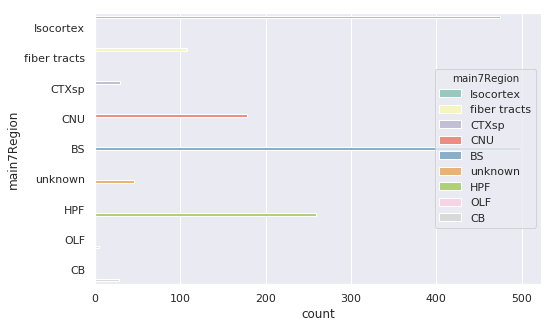

In [5]:
ct = somaRegDF["main7Region"].value_counts().sort_values(ascending=False)
thre = 0
sns.set(rc={'figure.figsize':(8,5)})
_ = sns.countplot(y="main7Region", 
                  data=somaRegDF.loc[somaRegDF.main7Region.isin(ct.index[ct>thre])],
                  hue = "main7Region", palette="Set3"
                 )


## 2.1.2) Projecting to three directions: "Horizontal","Coronal","Sagittal"

**2.1.2.1) By setting color="majorSOMA" in cell_in_map, the soma point will be shown with 7 major regions**
* Here set the 'Cluster' column in ns.metadata to be the region name.

**2.1.2.2) By setting color="soma" in cell_in_map, the soma point will be shown with 256 colors**
* No need to set the 'Cluster' column in ns.metadata to be the region name.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
    from neuro_morpho_toolbox.plot import cell_in_map
    fig, ax = plt.subplots(3,1, figsize=(7.5, 10))
    cur_list = ns.metadata.index.tolist()
    cell_in_map(ns.neurons, cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="soma",alpha=1,ax=ax[0])
    cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation, 
                view="Coronal", color="soma", alpha=1,ax=ax[1])
    cell_in_map(ns.neurons,cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Sagittal", color="soma", alpha=1, ax=ax[2])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```

**2.1.2.1)  Plot singel view('Horizontal') with only 7 major regions**

Illustrating soma locations inside a brain from horizontal view:


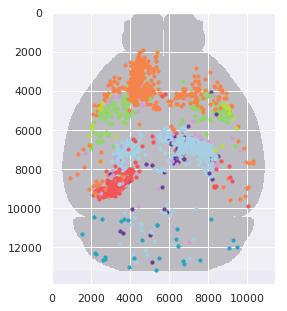

In [6]:
from neuro_morpho_toolbox.plot import cell_in_map
fig, ax =  plt.subplots(1,1)
cur_list = ns.metadata.index.tolist()
somaRegDF['Cluster']= somaRegDF.loc[:,'main7Region']
somaRegDF
cell_in_map(ns.neurons, cur_list, somaRegDF,ccf_annotation=nmt.annotation,view="Horizontal",color="majorsoma",ax=ax
           )
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

**2.1.2.2) Plot singel view('Horizontal') with all regions**

Illustrating soma locations inside a brain from horizontal view:


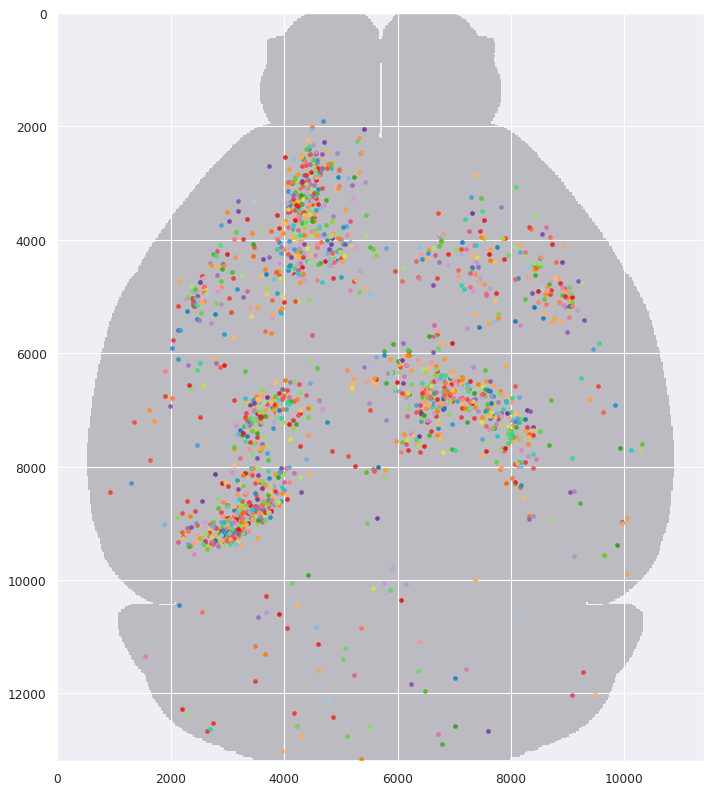

In [7]:
from neuro_morpho_toolbox.plot import cell_in_map
cur_list = ns.metadata.index.tolist()
somaRegDF
cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation,view="Horizontal", color="soma")
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

## 2.1.3) Use wordcloud to illustrate the information
* Not going to write into the pkg just to show the result

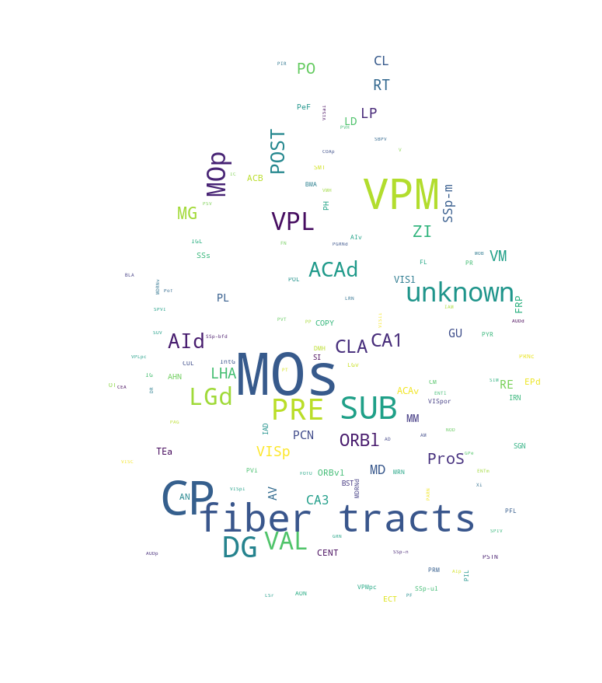

In [8]:
import jieba               
from wordcloud import WordCloud   
from PIL import Image
img = np.array(Image.open("/home/penglab/Desktop/mask.png"))
region_all, count = np.unique(somaRegDF['Region'], return_counts=True)
somaDIC = {}
for i in range(len(region_all)):
    #if region_all[i] == 'fiber tracts':
        #continue
    somaDIC[region_all[i]] = count[i]

wc = WordCloud(background_color='white',width=240,height=160,max_font_size=75,min_font_size=5,
               colormap="viridis", mask = img)
wc.generate_from_frequencies(somaDIC)
#save the file
wc.to_file('/home/penglab/Desktop/WC.png') 
# Show the plot
plt.figure(figsize=(10,20)) 
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()


## 1.1) Analyze soma location to obtain confident list

**Read the downsample-25 array with selected CCF region**

<blockquote>Example
    
```Python
nmt.ccfArray
```
</blockquote>

**Read the 6-nearest neighbor Contour Matrix with CCF index on**

* Originally, selected CCF has *316* regions, after using all the selected index to replace the child region, there are *337* regions.
* Therefore, there are 23 regions that show up in the nrrd array but have not been mentioned in the above selected CCF or its child region

<blockquote>Example
    
```Python
nmt.Contour01
```
</blockquote>

***Use nmt.disCal to obtain a DataFrame with columns ['x', 'y', 'z', 'SqEuclidean', 'min_Euclidean']***

<blockquote>Example
</blockquote>

```Python
    somaDis = nmt.disCal(ns.features['soma_features'].raw_data,
                         nmt.Contour01,nmt.ccfArray, 10, flipF = True)
```


In [9]:
pickle_in = open("/home/penglab/NMTcode/somaDis.pickle","rb")
example_ = pickle.load(pickle_in)
somaDis = example_[0]

SelectedDF is obtained by throwing the unknown region and fiber tracts soma away

In [10]:
selectedDF = somaDis[somaDis['SqEuclidean'] != 'unknown'].copy()
selectedDF = selectedDF[selectedDF['Region'] != 'fiber tracts'].copy()
confi_list = selectedDF.index.tolist()
print('Number of confident neurons are '+ str(len(confi_list)))
se_list = selectedDF.index.tolist()

Number of confident neurons are 1113


## Calculate ARI according to a given list

### Generate the dataframe using pickCLUSTERpara(method)

<blockquote>Example</blockquote>

```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy',se_list)
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans',se_list)
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan',se_list)
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan',se_list)
    snn_resultDF = ns.pickCLUSTERpara('snn',se_list)
    
```
or if want to calculate ARI for all neurons, just use
```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy')
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans')
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan')
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan')
    snn_resultDF = ns.pickCLUSTERpara('snn')
```

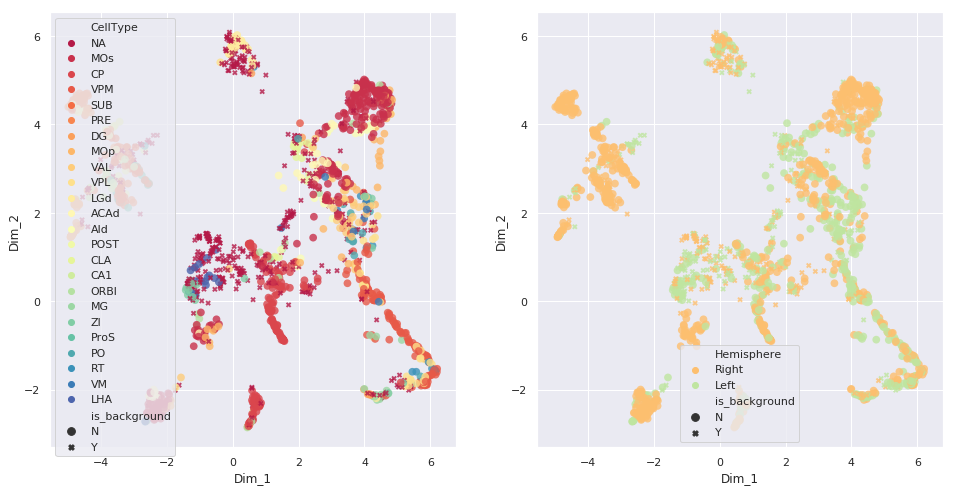

In [11]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

hier_resultDF = ns.pickCLUSTERpara('hierarchy',se_list)
hier_resultDF.to_excel('/home/penglab/NMTcode/hier_resultDF.xlsx')


In [12]:
import pandas as pd
hier_resultDF = pd.read_excel('/home/penglab/NMTcode/hier_resultDF.xlsx', index_col=0)
kmeans_resultDF = pd.read_excel('/home/penglab/NMTcode/kmeans_resultDF.xlsx', index_col=0)
dbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/dbscan_resultDF.xlsx', index_col=0)
hdbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/hdbscan_resultDF.xlsx', index_col=0)
snn_resultDF = pd.read_excel('/home/penglab/NMTcode/snn_resultDF.xlsx', index_col=0)

### Print out the most proper parameter by maximizing ARI

<blockquote>Example</blockquote>

```Python
    hierbest = nmt.findBESTpara(hier_resultDF,[15,45],16)
    kmeansbest = nmt.findBESTpara(kmeans_resultDF,[15,45],16)
    dbscanbest = nmt.findBESTpara(dbscan_resultDF,[15,45],16)
    hdbscanbest = nmt.findBESTpara(hdbscan_resultDF,[15,45],16)
    snnbest = nmt.findBESTpara(snn_resultDF,[15,45],16)
```

In [13]:
hierbest = nmt.findBESTpara(hier_resultDF,[15,45],16)
kmeansbest = nmt.findBESTpara(kmeans_resultDF,[15,45],16)
dbscanbest = nmt.findBESTpara(dbscan_resultDF,[15,45],16)
hdbscanbest = nmt.findBESTpara(hdbscan_resultDF,[15,45],16)
snnbest = nmt.findBESTpara(snn_resultDF,[15,45],16)

Available parameters are: 
ARI is 0.3224075308792257, and corresponding parameter is {'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
ARI is 0.3224075308792257, and corresponding parameter is {'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
ARI is 0.3224075308792257, and corresponding parameter is {'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
ARI is 0.3224075308792257, and corresponding parameter is {'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
ARI is 0.3224075308792257, and corresponding parameter is {'L_method': 'weighted', 'L_metric': 'braycurtis', 'cri

{'n_clusters': 26, 'init': 'random', 'n_init': 12, 'max_iter': 300, 'tol': 0.03337326996032604, 'precompute_distances': True, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'full'}
Available parameters are: 
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 33, 'p': None, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'brute', 'leaf_size': 28, 'p': 5, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'ball_tree', 'leaf_size': 32, 'p': 9, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metr

ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 29, 'p': None, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 28, 'p': None, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 27, 'p': None, 'n_jobs': None}
ARI is 0.3111506585974119, and corresponding parameter is {'eps': 0.22313016014842982, 'min_samples': 9, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 26, 'p': None, 'n_jobs': None}
Available parameters are: 
{'min_cluster_size': 5, 'metric': 'l2', 'alpha': 1.4, 'min_samples': 9, 'p': 2, 'algorithm': 'generic', 'leaf

## Using co-clustering towards the selected parameters

<blockquote>Example</blockquote>

```Python
AP_snn = ns.para_cocluster('SNN_community',snnbest,30, 5000)
AP_snnDF = pd.DataFrame(data=AP_snn, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_snnDF.to_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx')

```



### Feature 1: projection patterns

In [14]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

In [15]:
def fre_Matrix2(fre_M, cluster_method,para_DF):
    clusterL = ns.metadata.index[random.sample(range(0,ns.metadata.shape[0]), int(ns.metadata.shape[0]*0.95))]
    para_chosen = eval(para_DF.loc[para_DF.index.tolist()[randrange(para_DF.shape[0])],'parameter'])
    _ = ns.get_clusters(method =cluster_method,karg_dict = para_chosen,neuron_list =clusterL)
    Crange, Ccounts = np.unique(ns.metadata.loc[clusterL,'Cluster'], return_counts = True)
    for iter_C in Crange:
        selected_row = ns.metadata.loc[clusterL,:]
        selected_row = selected_row[selected_row["Cluster"]==iter_C]
        Clist = selected_row.index.tolist()
        fre_M.loc[Clist,Clist] = fre_M.loc[Clist,Clist] + 1
    return fre_M.values

In [16]:
import random
from random import randrange
import numpy as np
import multiprocessing
import time


def para_cocluster2(cluster_method,para_DF,corenum, run_num):
    start = time.perf_counter ()
    start=time.time()
    cores = corenum#multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=cores)
    fre_M_t = pd.DataFrame(index = ns.UMAP.index, columns =ns.UMAP.index)
    fre_M_t [fre_M_t.isnull()]=0
    pool_list=[]
    result_list=[]
    for i in range(run_num):
        pool_list.append(pool.apply_async(fre_Matrix2, (fre_M_t, cluster_method, para_DF)))

    result_list=[xx.get() for xx in pool_list]
    print(sum([xx for xx in  result_list]))
    pool.close()
    pool.join()
    elapsed = (time.time() - start)
    print('Time needed to run Hierarchy is '+ str(elapsed))
    return sum([xx for xx in  result_list])


AP_hier = para_cocluster2('Hierarchy',hierbest,30, 5000)

AP_hierDF = pd.DataFrame(data=AP_hier, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_hierDF.to_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx')


AP_kmeans = para_cocluster2('Kmeans',kmeansbest,30, 5000)

AP_kmeansDF = pd.DataFrame(data=AP_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_kmeansDF.to_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx')


AP_dbscan = para_cocluster2('DBSCAN',dbscanbest,30, 5000)

AP_dbscanDF = pd.DataFrame(data=AP_dbscan, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_dbscanDF.to_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx')


AP_hdbscan = para_cocluster2('HDBSCAN',hdbscanbest,30, 5000)

AP_hdbscanDF = pd.DataFrame(data=AP_hdbscan, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_hdbscanDF.to_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx')


AP_snn = para_cocluster2('SNN_community',snnbest,30, 5000)

AP_snnDF = pd.DataFrame(data=AP_snn, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_snnDF.to_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx')


In [20]:
AP_hierDF = pd.read_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx', index_col=0)
AP_kmeansDF = pd.read_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx', index_col=0)
AP_dbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx', index_col=0)
AP_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx', index_col=0)
AP_snnDF = pd.read_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx', index_col=0)

## Performing hierarchy clustering towards cocluster result

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


In [21]:
_ = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
_ = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20)

0.29028498760158344
0.27919728339292915


In [22]:
_ = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
_ = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20)

0.31639126815470914
0.28347703426581106


In [23]:
_ = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
_ = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20)

0.22600006361534364
0.22881599593523946


In [24]:
_ = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
_ = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20)

0.16392383886351428
0.16956924930493733


In [25]:
_ = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
_ = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20)

0.27539667166016674
0.2524528244605835


## Illustrating clustering result
   * By flipping the neurons
   
<blockquote>Example</blockquote>


```Python
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[nsFLIP] = pickle.load(pickle_in)
_ = nsFLIP.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

for iterK in ns.neurons.keys():
    temp = nsFLIP.neurons[iterK].swc
    idx = temp[temp['z']>nmt.annotation.array.shape[2]*nmt.annotation.space['z']*0.5].index.tolist()
    temp.loc[idx,'z'] =nmt.annotation.array.shape[2]*nmt.annotation.space['z'] -  temp.loc[idx,'z']
    nsFLIP.neurons[iterK].swc = temp
    
_ = nsFLIP.bestCoCluster(AP_hierDF, nmt.get_group_colors(nsFLIP.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 45, selected_list= se_list)
NeuronAll = []
for iterC in  list(nsFLIP.metadata['Cluster'].unique()):
    NeuronAll. append(nsFLIP.metadata[nsFLIP.metadata['Cluster']==iterC].index.tolist())
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(9,5, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 5 == 0 and i !=0:
        i = 0
        j = j+1
    cell_in_map(nsFLIP.neurons, iterL, nsFLIP.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    ax[j,i].axis('off')
    i = i+1

plt.savefig('/home/penglab/Desktop/Cell_in_map_flip.pdf', bbox_inches='tight')
plt.show()
    #fig.savefig('../Figure/Cell_in_map.pdf')
    
```


0.2685572498338201


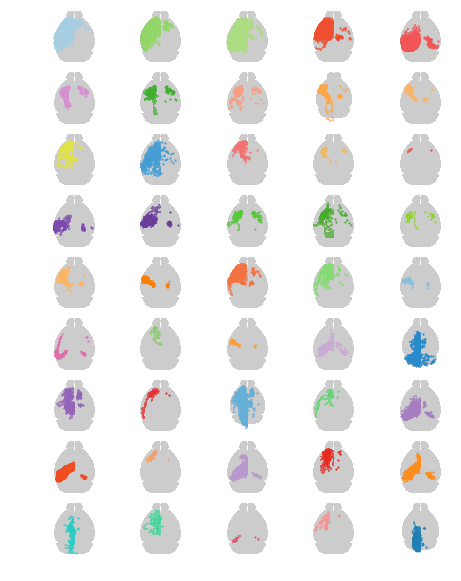

In [26]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[nsFLIP] = pickle.load(pickle_in)
_ = nsFLIP.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

for iterK in ns.neurons.keys():
    temp = nsFLIP.neurons[iterK].swc
    idx = temp[temp['z']>nmt.annotation.array.shape[2]*nmt.annotation.space['z']*0.5].index.tolist()
    temp.loc[idx,'z'] =nmt.annotation.array.shape[2]*nmt.annotation.space['z'] -  temp.loc[idx,'z']
    nsFLIP.neurons[iterK].swc = temp
    
_ = nsFLIP.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(nsFLIP.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 45, selected_list= se_list)
NeuronAll = []
for iterC in  list(nsFLIP.metadata['Cluster'].unique()):
    NeuronAll. append(nsFLIP.metadata[nsFLIP.metadata['Cluster']==iterC].index.tolist())
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(9,5, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 5 == 0 and i !=0:
        i = 0
        j = j+1
    cell_in_map(nsFLIP.neurons, iterL, nsFLIP.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    ax[j,i].axis('off')
    i = i+1

plt.savefig('/home/penglab/Desktop/Cell_in_map_flip.pdf', bbox_inches='tight')
plt.show()
    #fig.savefig('../Figure/Cell_in_map.pdf')
    

### Feature 2: Soma Location

In [157]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster,inconsistent
def furtherCLUSTER(input_ns,max_cluster,return_ns = True):
    #_ = input_ns.ReduceDimUMAP(feature_set="soma_features", n_neighbors=100)
    #_ = input_ns.ReduceDimUMAP(feature_set="soma_features", n_neighbors=100)
    typeR, typeC = np.unique(input_ns.metadata['Cluster'] , return_counts = True)
    for label_idx in typeR:
        if input_ns.features['soma_features'].raw_data[input_ns.metadata['Cluster']== label_idx].shape[0] == 1:
            continue
        linkmethod = ['single', 'complete','average','weighted','centroid','median','ward']
        paraDF = pd.DataFrame(columns =['method','CCC'],index = linkmethod)
        paraDF.loc[:,'method'] = linkmethod
        for iter_m in linkmethod:
            Y = distance.pdist(np.asarray(input_ns.features['soma_features'].raw_data[input_ns.metadata['Cluster']== label_idx]))
            Z = linkage(Y, method = iter_m)
            c, coph_dists = hierarchy.cophenet(Z,Y)
            paraDF.loc[iter_m,'cophentic_correlation_dis'] = c
        paraDF.sort_values(by='cophentic_correlation_dis', ascending = False, inplace = True)
        LinkageData = hierarchy.linkage(distance.pdist(np.asarray(ns.features['soma_features'].raw_data[input_ns.metadata['Cluster']== label_idx])), method = paraDF.iloc[0,0])
        cur_clusters = fcluster(LinkageData ,max_cluster,criterion='maxclust')
        input_ns.metadata.loc[(input_ns.metadata[input_ns.metadata['Cluster']==label_idx].index).tolist(),'Cluster'] = [str(label_idx) + str('_')  + 'C' + str(i) for i in cur_clusters]
       
    typeR, typeC = np.unique(input_ns.metadata['Cluster'] , return_counts = True)
    outputDF = pd.DataFrame(index = typeR)
    for label_idx in typeR:
        outputDF.loc[label_idx,'swc_in'] = str(input_ns.metadata[input_ns.metadata['Cluster']==label_idx].index.tolist())
        outputDF.loc[label_idx,'swc_num'] = len(input_ns.metadata[input_ns.metadata['Cluster']==label_idx].index.tolist())
    if return_ns:
        return input_ns
    else:
        return outputDF

In [158]:
furtherCLUSTER(nsFLIP,3,False)

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value en

,swc_in,swc_num
C10_C1_C1,"['18457_00013', '18464_00045', '18465_00241']",3.0
C10_C2_C1,"['18455_00255', '18457_00049']",2.0
C10_C3,['17545_00162'],1.0
C11_C1_C1,"['AA0433', 'AA0501']",2.0
C11_C1_C2,"['AA0056', 'AA0086', 'AA0087', 'AA0090', 'AA01...",52.0
C11_C1_C3,['AA0989'],1.0
C11_C2_C1,"['AA0011', 'AA0012', 'AA0119', 'AA0121', 'AA01...",22.0
C11_C2_C2,"['AA0132', 'AA0583', 'AA0584', 'AA0587', 'AA06...",14.0
C11_C2_C3,['AA0945'],1.0
C11_C3,['AA0956'],1.0


0.2685572498338201


/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars



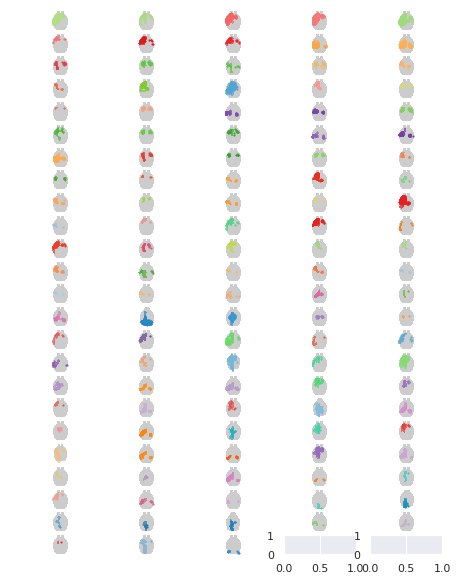

In [156]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[nsFLIP] = pickle.load(pickle_in)
_ = nsFLIP.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

for iterK in ns.neurons.keys():
    temp = nsFLIP.neurons[iterK].swc
    idx = temp[temp['z']>nmt.annotation.array.shape[2]*nmt.annotation.space['z']*0.5].index.tolist()
    temp.loc[idx,'z'] =nmt.annotation.array.shape[2]*nmt.annotation.space['z'] -  temp.loc[idx,'z']
    nsFLIP.neurons[iterK].swc = temp
    
_ = nsFLIP.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(nsFLIP.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 45, selected_list= se_list)

nsFLIP = furtherCLUSTER(nsFLIP,3)
NeuronAll = []
for iterC in  list(nsFLIP.metadata['Cluster'].unique()):
    NeuronAll. append(nsFLIP.metadata[nsFLIP.metadata['Cluster']==iterC].index.tolist())
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(len( NeuronAll)//5+1,5, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 5 == 0 and i !=0:
        i = 0
        j = j+1
    cell_in_map(nsFLIP.neurons, iterL, nsFLIP.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    ax[j,i].axis('off')
    i = i+1

plt.savefig('/home/penglab/Desktop/Cell_in_map_flip.pdf', bbox_inches='tight')
plt.show()
    #fig.savefig('../Figure/Cell_in_map.pdf')
    

0.2685572498338201


/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars



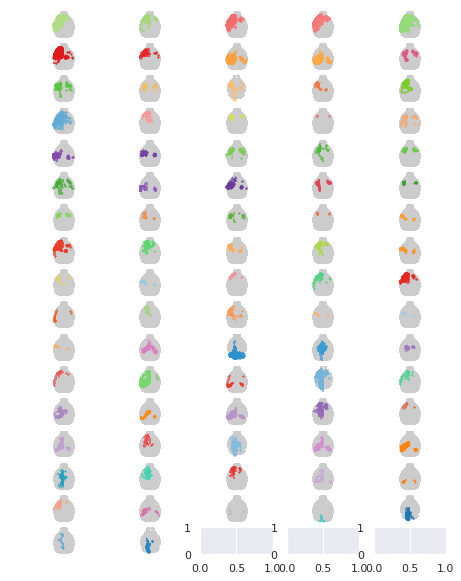

In [159]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[nsFLIP2] = pickle.load(pickle_in)
_ = nsFLIP2.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

for iterK in ns.neurons.keys():
    temp = nsFLIP2.neurons[iterK].swc
    idx = temp[temp['z']>nmt.annotation.array.shape[2]*nmt.annotation.space['z']*0.5].index.tolist()
    temp.loc[idx,'z'] =nmt.annotation.array.shape[2]*nmt.annotation.space['z'] -  temp.loc[idx,'z']
    nsFLIP2.neurons[iterK].swc = temp
    
_ = nsFLIP2.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(nsFLIP2.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 45, selected_list= se_list)

nsFLIP2 = furtherCLUSTER(nsFLIP2,2)
NeuronAll = []
for iterC in  list(nsFLIP2.metadata['Cluster'].unique()):
    NeuronAll. append(nsFLIP2.metadata[nsFLIP2.metadata['Cluster']==iterC].index.tolist())
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(len( NeuronAll)//5+1,5, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 5 == 0 and i !=0:
        i = 0
        j = j+1
    cell_in_map(nsFLIP2.neurons, iterL, nsFLIP2.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    ax[j,i].axis('off')
    i = i+1

#plt.savefig('/home/penglab/Desktop/Cell_in_map_flip.pdf', bbox_inches='tight')
plt.show()
    #fig.savefig('../Figure/Cell_in_map.pdf')
    

In [160]:
furtherCLUSTER(nsFLIP2,3,False)

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1747: RuntimeWarning:

invalid value en

,swc_in,swc_num
C10_C1_C1,"['18457_00013', '18464_00045', '18465_00241']",3.0
C10_C2_C1,"['17545_00162', '18455_00255', '18457_00049']",3.0
C11_C1_C1,"['AA0433', 'AA0501']",2.0
C11_C1_C2,"['AA0056', 'AA0086', 'AA0087', 'AA0090', 'AA01...",52.0
C11_C1_C3,['AA0989'],1.0
C11_C2_C1,"['AA0011', 'AA0012', 'AA0119', 'AA0121', 'AA01...",36.0
C11_C2_C2,['AA0945'],1.0
C11_C2_C3,['AA0956'],1.0
C12_C1_C1,"['236174_3893-3908-X17507-Y26071_finalized', '...",4.0
C12_C1_C2,"['17302_00024', '18457_00170', '18457_00184', ...",13.0


In [133]:
_ = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
furtherCLUSTER(ns,3)

0.31639126815470914


,swc_in
C10_C1,"['17545_00089', '18464_00192', '236174_3729_03..."
C10_C2,"['AA0013', 'AA0014', 'AA0037', 'AA0061', 'AA00..."
C10_C3,"['17109_2401_2500_X9695_Y9693_QCed', '17109_26..."
C11_C1,"['17302_00074', '17302_00085', '17302_00091', ..."
C11_C2,"['17302_00013', '17302_00014', '17302_00015', ..."
C11_C3,"['18455_00158', '18465_00246', 'AA0758']"
C12_C1,"['17302_00019', '17302_00023', '17302_00075', ..."
C12_C2,"['18458_00612', 'AA0919']"
C12_C3,"['17302_00030', '17302_00033', '17302_00047', ..."
C13_C1,"['AA0067', 'AA0239', 'AA0284', 'AA0900']"


## Researching on main soma location and projection feature for each cluster
<blockquote>Example: Obtain dataframe containing ['Main_SOMA', 'Main_Proj', 'Proj_Length'] for each cluster
    
```Python
    pd.set_option('display.max_columns', None)

    pd.set_option('display.max_rows', None)

    pd.set_option('max_colwidth',100)

    RESULT = detailCluster(ns,5,[])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```


In [29]:
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt



def detailCluster(input_ns,first_n, interestedL, returnSUMMARY = True):
    normaF = 0
    somaregionDF = input_ns.features['soma_features'].region
    # DF with columns for all the 632 regions
    axonregionDF = input_ns.features['projection_features'].raw_data.round(2)  

    colname = ['Cluster Num','soma_region List','axon Region List']

    typeR, typeC = np.unique(input_ns.metadata['Cluster'] , return_counts = True)
    detailDF = pd.DataFrame(index = typeR,columns = ['swc_list','soma_region','max_soma','total_soma',
                                                             'max_axon'])

        # for each cluster result UNDER EACH PARAMETER
    somaCLUSTERlist = []
    axonCLUSTERlist = []

    #axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
    #for each cluster
    for label_idx in detailDF.index:
        #print( label_idx)
        axonTEMPdf = pd.DataFrame(index = axonregionDF.columns)# index is all the 632 regions
        # swcINlabel: A DF with cols [SomaRegion,Hemisphere,CellType,Cluster]
        swcINlabel = input_ns.metadata[input_ns.metadata['Cluster']==label_idx]
        detailDF.loc[label_idx,'swc_list'] = (swcINlabel.index).tolist()
        #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
        detailDF.loc[label_idx,'soma_region'] = swcINlabel['SomaRegion'].tolist()
        del_soma_region = detailDF.loc[label_idx,'soma_region']
        while 'unknown' in del_soma_region:
            del_soma_region.remove('unknown')
            del_soma_region.append('others')
        while 'fiber tracts' in del_soma_region:
            del_soma_region.remove('fiber tracts')
            del_soma_region.append('others')
        IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
        #sort the counting
        count_sort_ind = np.argsort(-IDcounts)
        dicitem = []
        for i in range(1,min(len(IDrange)+1,first_n)):
            dicitem.append(str(i)+'somaR')
        for i in range(1,min(len(IDrange)+1,first_n)):
            dicitem.append(str(i)+'somaC')
        #select the first three regions
        dicvalue = IDrange[count_sort_ind][0:min(first_n-1,len(IDrange))]
        dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(first_n-1,len(IDrange))])
        detailDF.loc[label_idx,'max_soma'] = str(dict(zip(dicitem, dicvalue)))
        detailDF.loc[label_idx,'total_soma'] = swcINlabel.shape[0]
        
        #axonregionDF, index is all the samples, columns to be all the regions
        axonregionDF.loc[:,'cluster'] = input_ns.metadata['Cluster'].copy()
        #axonLABEL stores all the rows(samples) under cluster label_idx
        axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
        axonLABEL.drop('cluster', axis=1,inplace=True)
        # axonTEMPdf: a DF with index being all the 632 regions without
        
        if 'contra_fiber tracts' in axonLABEL.index:
            axonLABEL.drop(index=['contra_fiber tracts'],inplace = True)
        if 'ipsi_fiber tracts' in axonLABEL.index:
            axonLABEL.drop(index=['ipsi_fiber tracts'],inplace = True)
        axonTEMPdf[label_idx]=axonLABEL.sum().round(2)  # axonTEMPdf.loc[:,label_idx]=axonLABEL.sum()
        if normaF:
            #normalize the sum
            axonTEMPdf = normalize(axonTEMPdf , log=True)
        if len(interestedL) ==0:
            interestedL = axonTEMPdf.index.tolist()
        interestDF = axonTEMPdf.loc[interestedL,:].copy()
        nonzeroIDX = interestDF[interestDF.loc[:,label_idx]>0].index
        interestDF = interestDF[interestDF.loc[:,label_idx]>0].copy()
        #corresponding to nonzero but not interested regions
        remainDF = axonTEMPdf.loc[list(set(axonTEMPdf.index.tolist()).difference(set(nonzeroIDX))),:]
        interestDF.loc['other',label_idx] = remainDF.sum(axis = 0, skipna = True)[0] 
        interestDF.sort_values(by=label_idx, ascending=False, inplace=True)
        
        dicitem = interestDF.index.tolist()
        dicvalue = interestDF.loc[:,label_idx]
        detailDF.loc[label_idx,'max_axon'] = str(dict(zip(dicitem, dicvalue)))
    summaryDF = pd.DataFrame(index = detailDF.index.tolist())
    for iterC in detailDF.index:
        summaryDF.loc[iterC,'Main_SOMA'] = str(list(eval(detailDF.loc[iterC,'max_soma']).values())[0:int(0.5*len(eval(detailDF.loc[iterC,'max_soma']).values()))-1])
        summaryDF.loc[iterC,'Main_Proj'] = str(list(eval(detailDF.loc[iterC,'max_axon']).keys())[0:first_n])
        summaryDF.loc[iterC,'Proj_Length'] = str(list(eval(detailDF.loc[iterC,'max_axon']).values())[0:first_n])    
    if returnSUMMARY:
        return summaryDF
    else:
        return detailDF

### Selected DF constraining input number of cluster


In [ ]:
subARI_sumDF = ARI_sumDF.copy()
subARI_sumDF = subARI_sumDF [subARI_sumDF ['RegionUsed']=='selected']
subARI_sumDF  = subARI_sumDF[subARI_sumDF['REALnum']<75]
subARI_sumDF  = subARI_sumDF[subARI_sumDF['REALnum']>45]

In [ ]:
sns.lineplot(x='REALnum', y="ARI",style="SL", 
             hue="AP",        data=subARI_sumDF )

## Choose SNN + Kmeans with 56 cluster

In [ ]:
sumCO = SL_kmeansDF + AP_snnDF
_ = ns.bestCoCluster(sumCO , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 56, 
                                                 selected_list= se_list, plotF = True)

In [ ]:
ax[9,2]

In [ ]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[nsFLIP] = pickle.load(pickle_in)
_ = nsFLIP.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

for iterK in ns.neurons.keys():
    temp = nsFLIP.neurons[iterK].swc
    idx = temp[temp['z']>nmt.annotation.array.shape[2]*nmt.annotation.space['z']*0.5].index.tolist()
    temp.loc[idx,'z'] =nmt.annotation.array.shape[2]*nmt.annotation.space['z'] -  temp.loc[idx,'z']
    nsFLIP.neurons[iterK].swc = temp
    
_ = nsFLIP.bestCoCluster(sumCO , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", 
                                                 return_str = True,return_hex = True), t = 56, 
                                                 selected_list= se_list)
NeuronAll = []
for iterC in  list(nsFLIP.metadata['Cluster'].unique()):
    NeuronAll. append(nsFLIP.metadata[nsFLIP.metadata['Cluster']==iterC].index.tolist())
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(10,5, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 5 == 0 and i !=0:
        i = 0
        j = j+1
    
    cell_in_map(nsFLIP.neurons, iterL, nsFLIP.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    print(j,i)
    ax[j,i].axis('off')
    i = i+1

plt.savefig('/home/penglab/Desktop/Cell_in_map_flip15Nov.pdf', bbox_inches='tight')
plt.show()

In [ ]:
RESULT = detailCluster(ns,5,[])

In [ ]:
summaryDF = pd.DataFrame(index = detailDF.index.tolist())
for iterC in detailDF.index:
    summaryDF.loc[iterC,'Main_SOMA'] = str(list(eval(detailDF.loc[iterC,'max_soma']).values())[0:int(0.5*len(eval(detailDF.loc[iterC,'max_soma']).values()))-1])
    summaryDF.loc[iterC,'Main_Proj'] = str(list(eval(detailDF.loc[iterC,'max_axon']).keys())[0:3])
    summaryDF.loc[iterC,'Proj_Length'] = str(list(eval(detailDF.loc[iterC,'max_axon']).values())[0:3])    

In [ ]:
summaryDF

In [ ]:
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt



def detailCluster(input_ns,interestedL):
    somaDF = input_ns.features['soma_features'].region
    axonDF = input_ns.features['projection_features'].raw_data

    somaregionDF = somaDF.copy()
    # DF with columns for all the 632 regions
    axonregionDF = axonDF.copy()      

    colname = ['Cluster Num','soma_region List','axon Region List']

    typeR, typeC = np.unique(input_ns.metadata['Cluster'] , return_counts = True)
    detailDF = pd.DataFrame(index = typeR,columns = ['swc_list','soma_region','max_soma','total_soma',
                                                             'max axon'])

        # for each cluster result UNDER EACH PARAMETER
    somaCLUSTERlist = []
    axonCLUSTERlist = []

    #axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
    #for each cluster
    for label_idx in detailDF.index:
        #print( label_idx)
        axonTEMPdf = pd.DataFrame(index = axonregionDF.columns)# index is all the 632 regions
        # swcINlabel: A DF with cols [SomaRegion,Hemisphere,CellType,Cluster]
        swcINlabel = input_ns.metadata[input_ns.metadata['Cluster']==label_idx]
        detailDF.loc[label_idx,'swc_list'] = (swcINlabel.index).tolist()
        #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
        detailDF.loc[label_idx,'soma_region'] = swcINlabel['SomaRegion'].tolist()
        del_soma_region = detailDF.loc[label_idx,'soma_region']
        while 'unknown' in del_soma_region:
            del_soma_region.remove('unknown')
            del_soma_region.append('others')
        while 'fiber tracts' in del_soma_region:
            del_soma_region.remove('fiber tracts')
            del_soma_region.append('others')
        IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
        #sort the counting
        count_sort_ind = np.argsort(-IDcounts)
        dicitem = []
        for i in range(1,min(len(IDrange)+1,first_n)):
            dicitem.append(str(i)+'somaR')
        for i in range(1,min(len(IDrange)+1,first_n)):
            dicitem.append(str(i)+'somaC')
        #select the first three regions
        dicvalue = IDrange[count_sort_ind][0:min(first_n-1,len(IDrange))]
        print(dicvalue)
        dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(first_n-1,len(IDrange))])
        print(dicvalue)
        detailDF.loc[label_idx,'max_soma'] = str(dict(zip(dicitem, dicvalue)))
        detailDF.loc[label_idx,'total_soma'] = swcINlabel.shape[0]
        
        #axonregionDF, index is all the samples, columns to be all the regions
        axonregionDF.loc[:,'cluster'] = input_ns.metadata['Cluster'].copy()
        #axonLABEL stores all the rows(samples) under cluster label_idx
        axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
        axonLABEL.drop('cluster', axis=1,inplace=True)
        # axonTEMPdf: a DF with index being all the 632 regions
        axonTEMPdf[label_idx]=axonLABEL.sum()# axonTEMPdf.loc[:,label_idx]=axonLABEL.sum()
        if 'contra_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['contra_fiber tracts'],inplace = True)
        if 'ipsi_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['ipsi_fiber tracts'],inplace = True)
        if normaF:
            #normalize the sum
            axonTEMPdf = normalize(axonTEMPdf , log=True)
        interestDF = axonTEMPdf.loc[interestList,:].copy()
        
        nonzeroIDX = interestDF[interestDF.loc[:,label_idx]>0].index
        interestDF = interestDF[interestDF.loc[:,label_idx]>0].copy()
        remainDF = axonTEMPdf.loc[list(set(axonTEMPdf.index.tolist()).difference(set(nonzeroIDX))),:]
        interestDF.loc['other',label_idx] = remainDF.sum(axis = 0, skipna = True)[0] 
        interestDF.sort_values(by=label_idx, ascending=False, inplace=True)
                
        dicitem = interestDF.index.tolist()
        dicvalue = interestDF.loc[:,label_idx]
        detailDF.loc[label_idx,'max axon'] = str(dict(zip(dicitem, dicvalue)))
        return detailDF.copy()

In [ ]:
import pickle
def generateNS(featureDF,ns_input,Z_sample,storePath,outname):
    if featureDF.shape!= (0,0):
        pickle_in = open("/home/penglab/FeaCal/ns.pickle","rb")
        example_ = pickle.load(pickle_in)
        ns_input= example_[0]

        index_origin = ns_input.metadata.index.tolist()
        ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, 
                                         metric='euclidean',PCA_first=True,n_PC=100)
        index_after = ns_input.UMAP.index.tolist()
        if len(index_after)>len(index_origin ):
            index_update = [i for i in index_after if i in index_origin ]
        else:
            index_update = [i for i in index_origin if i in index_after ]
        
        ns_input.metadata = ns_input.metadata.loc[index_update,:]
    cur_clusters = coclusterResult(Z_sample)
    ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters] 
    _ = ns_input.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")
    return ns_input

In [ ]:
AP_hierDF  = DM_hierDF

In [ ]:
Ztemp= bestCOCLUSTER(AP_hierDF)
generateNS(pd.DataFrame(),ns,Ztemp,'/home/penglab/FeaCal/','AP_hier_ns')

In [ ]:
_ = ns.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")

In [ ]:
DM_kmeans = para_cocluster('Kmeans', par_kmeans2,30, 5000,ns)
DM_kmeansDF = pd.DataFrame(data=DM_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
DM_kmeansDF.to_excel('/home/penglab/FeaCal/dataSource/denMor/DM_kmeansDF.xlsx')



In [ ]:
# df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.xlsx", index_col=[0])
# metadata = ns.features['soma_features'].region
# df = df.loc[metadata.index]
# df.to_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.284_cells.xlsx")

In [ ]:
df = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
pickle.dump([metadata], open("metadata.pickle", "wb"))

## Color setting

In [ ]:
bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(matplotlib.colors.to_rgb("C"+str(i))):
        tp.append(str(int(j*255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
   
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_celltype_colors(metadata):
    u_celltypes = sorted(list(set(metadata.Celltype)))
    color_list = cl.to_rgb(cl.interp(paired, len(u_celltypes)))
    color_list = [rgb_to_list(i) for i in color_list]
    celltype_colors = dict(zip(u_celltypes, color_list))
    if "Others" in u_celltypes:
        celltype_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return celltype_colors

celltype_color_dict = get_celltype_colors(metadata)

pickle.dump([celltype_color_dict], open("colors.pickle", "wb"))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,8))
for i, key in enumerate(list(celltype_color_dict.keys())):
    ax.scatter(0.001, len(celltype_color_dict) - i, c=celltype_color_dict[key], s=100)
    ax.text(0.002, len(celltype_color_dict) - i, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
    ax.set_xlim(0, 0.01)
    ax.axis("off")

In [ ]:
ns.metadata["CellType"] = metadata.loc[ns.metadata.index, "Celltype"]
clusters = pd.read_csv("clusters.csv", index_col=[0])
ns.metadata['Cluster'] = clusters.loc[ns.metadata.index, "Cluster"]
ns.metadata["CellType_note"] = metadata.loc[ns.metadata.index, "Celltype_note"]

In [ ]:
pickle.dump([ns], open("neuron_set.pickle", "wb"))

In [ ]:
ns.features['projection_features'].normalize(log=True)
pickle.dump([ns.features['projection_features']], open("features_projection.pickle", "wb"))

In [ ]:
ns.features['projection_features'].scaled_data

## Feature 2: soma locations

In [ ]:
pickle.dump([ns.features['soma_features']], open("features_soma.pickle", "wb"))

## Feature 3: axon morphological features

In [ ]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [ ]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [ ]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

## Feature 4: dendrite morphological features

In [ ]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

In [ ]:
print(np.log(10000), np.log(5000))